In [1]:
import pandas as pd

# Define the subjects, predicates, and objects
subjects =   ['Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Alice', 'Bob', 'Bob', 'David','Eve', 'Frank']
predicates = ['like', 'like', 'like', 'like', 'like', 'has', 'has', 'has', 'has', 'has',  'has']
objects =    ['movie', 'movie', 'movie', 'music', 'music', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog']

# Create a dataframe
df = pd.DataFrame({'subject': subjects, 'predicate': predicates, 'object': objects})
df.to_csv('train_TransE.tsv', sep='\t', index=False, header=False)

df

,subject,predicate,object
0,Alice,like,movie
1,Bob,like,movie
2,Charlie,like,movie
3,David,like,music
4,Eve,like,music
5,Alice,has,cat
6,Bob,has,cat
7,Bob,has,dog
8,David,has,dog
9,Eve,has,dog


In [2]:
from pykeen.triples import TriplesFactory

# Assuming your dataframe has columns 'subject', 'predicate', 'object'
triples_factory = TriplesFactory.from_labeled_triples(
    triples=df[['subject', 'predicate', 'object']].values,
)

training = triples_factory
validation = triples_factory
testing = triples_factory

d=training
id_to_entity={v: k for k, v in d.entity_to_id.items()}
id_to_relation={v: k for k, v in d.relation_to_id.items()}

# Display the first few triples
triples_factory.triples

Reconstructing all label-based triples. This is expensive and rarely needed.


array([['Alice', 'has', 'cat'],
       ['Alice', 'like', 'movie'],
       ['Bob', 'has', 'cat'],
       ['Bob', 'has', 'dog'],
       ['Bob', 'like', 'movie'],
       ['Charlie', 'like', 'movie'],
       ['David', 'has', 'dog'],
       ['David', 'like', 'music'],
       ['Eve', 'has', 'dog'],
       ['Eve', 'like', 'music'],
       ['Frank', 'has', 'dog']], dtype='<U7')

In [3]:
from pykeen.pipeline import pipeline



result = pipeline(
    model='TransE',
    loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=3),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=100, use_tqdm_batch=False),  # Increase the number of epochs
)

# The trained model is stored in the pipeline result
model = result.model

No random seed is specified. Setting to 632822520.
No cuda devices were available. The model runs on CPU


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/11.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


In [4]:
from pykeen.evaluation import RankBasedEvaluator

# Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(result.model, testing.mapped_triples, additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cpu:   0%|          | 0.00/11.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


Hits@1: 1.0
Hits@3: 1.0
Hits@5: 1.0
Hits@10: 1.0
Mean Reciprocal Rank: 1.0


(-1.0, 1.0)

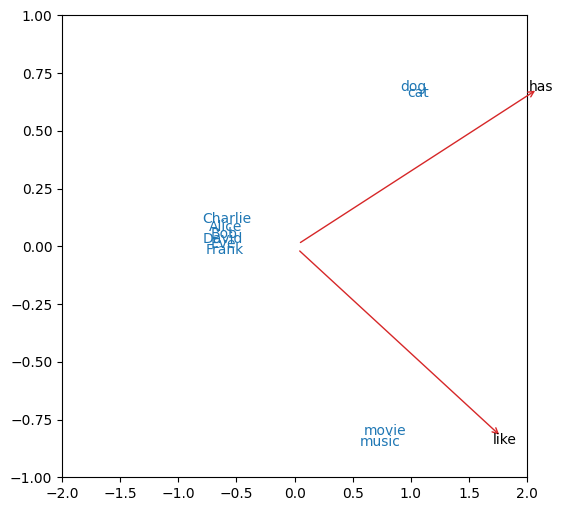

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure(figsize=(6, 6))
pca = PCA(n_components=2)
entity_embeddings = model.entity_representations[0](indices=None).detach().numpy()
m = pca.fit(entity_embeddings)

eu = m.transform(entity_embeddings)
# plt.plot(eu[:, 0], eu[:, 1],'.b')
for i, entity in enumerate(triples_factory.entity_id_to_label):
    plt.annotate(
        text=id_to_entity[entity],
        xy=(eu[i, 0], eu[i, 1]),
        color="tab:blue",
        ha="center", va="center"
    )

    
relation_embeddings = model.relation_representations[0](indices=None).detach().numpy()
ru = pca.transform(relation_embeddings)
for i, relation in enumerate(triples_factory.relation_id_to_label):
    plt.annotate(
        text=id_to_relation[relation],
        xy=(0,0), xytext=(ru[i, 0], ru[i, 1]),
        arrowprops=dict(
            arrowstyle="<-",
            color="tab:red",
            shrinkA=5,
            shrinkB=5,
            patchA=None,
            patchB=None,
            connectionstyle="arc3,rad=0."
        )
    )

plt.xlim([-2, 2])
plt.ylim([-1, 1])